In [7]:
import csv
import timeit
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import cuda, jit


In [11]:
# shared memory и reduction
@cuda.jit
def optimized_cuda_vector_sum(vector, partial_sums):
    shared_mem = cuda.shared.array(32, dtype=numba.float32)
    tid = cuda.threadIdx.x
    i = cuda.blockIdx.x * cuda.blockDim.x + tid

    # Загрузка данных в shared memory
    shared_mem[tid] = vector[i] if i < vector.size else 0
    cuda.syncthreads()

    # Алгоритм reduction в shared memory
    step = 1
    while step < cuda.blockDim.x:
        if tid % (2 * step) == 0:
            shared_mem[tid] += shared_mem[tid + step]
        step *= 2
        cuda.syncthreads()

    # Сохранение результата блока
    if tid == 0:
        partial_sums[cuda.blockIdx.x] = shared_mem[0]

# JIT-функция для суммирования на CPU
@jit(nopython=True, cache=True)
def cpu_jit_vector_sum(vector):
    return np.sum(vector)

# Функция для суммирования на CPU без оптимизации
def cpu_vector_sum(vector):
    return np.sum(vector)

# Функция для запуска CUDA-суммирования
def run_cuda_vector_sum(vector):
    threads_per_block = 32
    blocks_per_grid = (vector.size + threads_per_block - 1) // threads_per_block

    partial_sums = cuda.device_array(blocks_per_grid, dtype=np.float32)
    d_vector = cuda.to_device(vector)

    optimized_cuda_vector_sum[blocks_per_grid, threads_per_block](d_vector, partial_sums)

    return np.sum(partial_sums.copy_to_host())


In [12]:
n = 10 ** 2
k = 5
number_of_tests = 12
results = np.zeros((k, 8))

results[:, 0] = [10 ** (4 + i) for i in range(k)]

for i in range(k):
    vector = np.random.rand(int(results[i, 0])).astype(np.float32)

    # Измерение времени выполнения
    results[i, 1] = timeit.timeit(lambda: cpu_vector_sum(vector), number=number_of_tests) / number_of_tests
    results[i, 2] = timeit.timeit(lambda: cpu_jit_vector_sum(vector), number=number_of_tests) / number_of_tests
    results[i, 3] = timeit.timeit(lambda: run_cuda_vector_sum(vector), number=number_of_tests) / number_of_tests
    results[i, 4] = timeit.timeit(lambda: vector.sum(), number=number_of_tests) / number_of_tests

    print(f"Vector size: {results[i, 0]:.0f}")
    print(f"CPU time: {results[i, 1]:.6f}s")
    print(f"CPU JIT time: {results[i, 2]:.6f}s")
    print(f"CUDA time: {results[i, 3]:.6f}s")
    print(f"Numpy sum time: {results[i, 4]:.6f}s")

results[:, 5] = results[:, 1] / results[:, 2]  # Speedup CPU JIT
results[:, 6] = results[:, 1] / results[:, 3]  # Speedup CUDA
results[:, 7] = results[:, 1] / results[:, 4]  # Speedup Numpy


Vector size: 10000
CPU time: 0.000110s
CPU JIT time: 0.005481s
CUDA time: 0.014752s
Numpy sum time: 0.000006s
Vector size: 100000
CPU time: 0.000029s
CPU JIT time: 0.000135s
CUDA time: 0.001265s
Numpy sum time: 0.000033s
Vector size: 1000000
CPU time: 0.000268s
CPU JIT time: 0.001278s
CUDA time: 0.001861s
Numpy sum time: 0.000245s
Vector size: 10000000
CPU time: 0.003117s
CPU JIT time: 0.013282s
CUDA time: 0.013597s
Numpy sum time: 0.003806s
Vector size: 100000000
CPU time: 0.034413s
CPU JIT time: 0.130609s
CUDA time: 0.113160s
Numpy sum time: 0.033304s


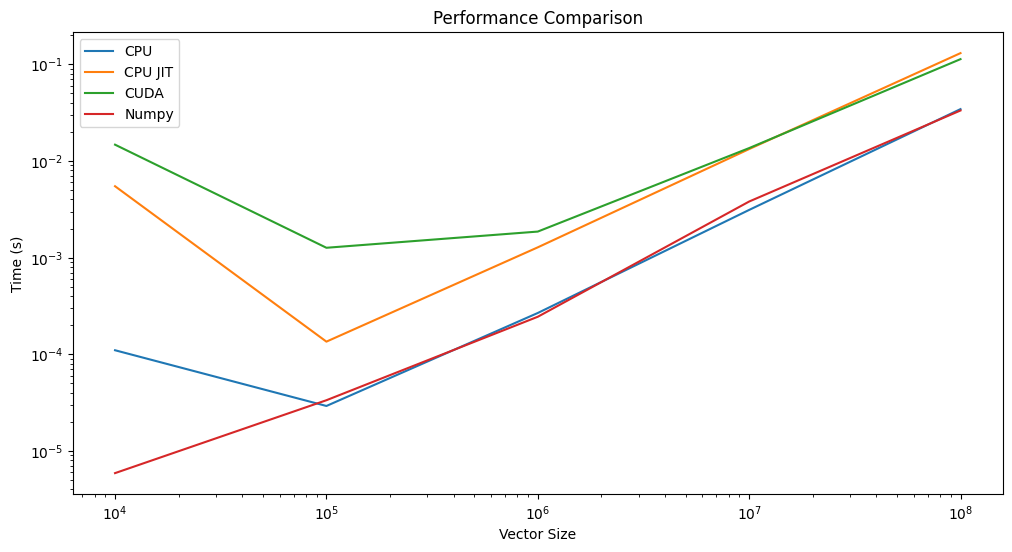

In [13]:
with open('results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Vector size", "CPU time (s)", "CPU JIT time(s)", "CUDA time(s)", "Numpy sum time(s)",
                     "CPU JIT speed up", "CUDA speed up", "Numpy sum speed up"])
    writer.writerows(results)

plt.figure(figsize=(12, 6))
plt.plot(results[:, 0], results[:, 1], label='CPU')
plt.plot(results[:, 0], results[:, 2], label='CPU JIT')
plt.plot(results[:, 0], results[:, 3], label='CUDA')
plt.plot(results[:, 0], results[:, 4], label='Numpy')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Vector Size')
plt.ylabel('Time (s)')
plt.legend()
plt.title('Performance Comparison')
plt.show()
